In [1]:
import argparse
import os
import shutil
import gzip

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.autograd import Variable

from dpp_nets.utils.language import Vocabulary, BeerDataset, custom_collate
from dpp_nets.layers.layers import ChunkTrainer, ChunkTrainerRel

from dpp_nets.utils.language import EvalSet

In [2]:
# Load saved checkpoint
model = 'shortwords1reg1.0reg_mean50.0lr0.001marginal_ckp.pth.tar'
model_dir = '/Users/Max/checkpoints/beer_reviews/marginal/' 
model_path = model_dir + model
model = torch.load(model_path, map_location=lambda storage, loc: storage)

In [3]:
from dpp_nets.utils.language import Vocabulary

embd_path = '/Users/Max/data/beer_reviews/review+wiki.filtered.200.txt.gz'
word_path = '/Users/Max/data/beer_reviews/reviews.all.train.words.txt.gz'

# Set-up Vocabulary
vocab = Vocabulary()
vocab.loadPretrained(embd_path)
vocab.setStops()
vocab.loadCorpus(word_path)
vocab.updateEmbedding()
vocab.setCuda(False)
vocab.EmbeddingBag.load_state_dict(model['embedding'])

In [4]:
EMBD_DIM = 200
KERNEL_DIM = 200
HIDDEN_DIM = 500
ENC_DIM = 200
TARGET_DIM = 3 if model['aspect'] in set(['all', 'short']) else 1

if model['mode'] == 'sents':
    trainer = ChunkTrainer(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)
else:
    trainer = ChunkTrainerRel(EMBD_DIM, HIDDEN_DIM, KERNEL_DIM, ENC_DIM, TARGET_DIM)

trainer.load_state_dict(model['model'])
trainer.activation = nn.Sigmoid()
trainer.reg = model['reg']
trainer.reg_mean = model['reg_mean']

rat_path = '/Users/Max/data/beer_reviews/annotations.json'
evalset = EvalSet(rat_path, vocab)

In [5]:
# Plot a table
print('__________________________Training Table__________________________')
for k, v in model['train_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['train_pred_loss'][k][0], model['train_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

__________________________Training Table__________________________
Epoch: 0 | Loss: 0.29047 | Pred Loss: 0.06136 | Reg Loss: 0.22911
Epoch: 1 | Loss: 0.26820 | Pred Loss: 0.04377 | Reg Loss: 0.22443
Epoch: 2 | Loss: 0.25764 | Pred Loss: 0.04039 | Reg Loss: 0.21725
Epoch: 3 | Loss: 0.24772 | Pred Loss: 0.04042 | Reg Loss: 0.20730
Epoch: 4 | Loss: 0.23384 | Pred Loss: 0.03762 | Reg Loss: 0.19622
Epoch: 5 | Loss: 0.22312 | Pred Loss: 0.03859 | Reg Loss: 0.18453
Epoch: 6 | Loss: 0.20964 | Pred Loss: 0.03762 | Reg Loss: 0.17201
Epoch: 7 | Loss: 0.19579 | Pred Loss: 0.03680 | Reg Loss: 0.15899
Epoch: 8 | Loss: 0.18337 | Pred Loss: 0.03773 | Reg Loss: 0.14564
Epoch: 9 | Loss: 0.16886 | Pred Loss: 0.03682 | Reg Loss: 0.13205


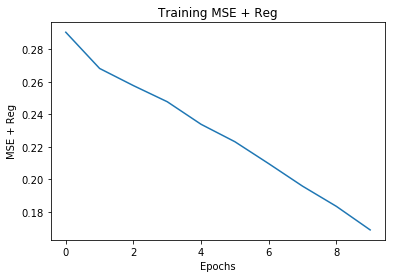

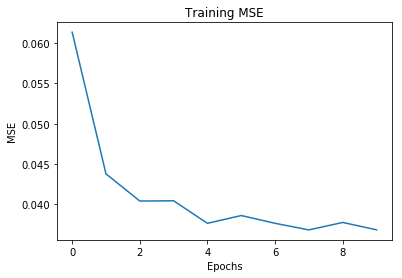

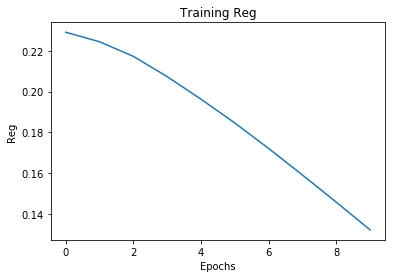

In [6]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['train_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Training MSE + Reg')
plot_floats(model['train_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Training MSE')
plot_floats(model['train_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Training Reg')

In [7]:
print('_________________________Validation Table_________________________')
for k, v in model['val_loss'].items():
    epoch, loss, pred_loss, reg_loss = k, v[0], model['val_pred_loss'][k][0], model['val_reg_loss'][k][0]
    print(str.join(" | ", ['Epoch: %d' % (epoch), 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

_________________________Validation Table_________________________
Epoch: 0 | Loss: 0.27043 | Pred Loss: 0.04463 | Reg Loss: 0.22579
Epoch: 1 | Loss: 0.26026 | Pred Loss: 0.04140 | Reg Loss: 0.21886
Epoch: 2 | Loss: 0.25042 | Pred Loss: 0.04137 | Reg Loss: 0.20905
Epoch: 3 | Loss: 0.23660 | Pred Loss: 0.03857 | Reg Loss: 0.19803
Epoch: 4 | Loss: 0.22597 | Pred Loss: 0.03960 | Reg Loss: 0.18637
Epoch: 5 | Loss: 0.21261 | Pred Loss: 0.03871 | Reg Loss: 0.17390
Epoch: 6 | Loss: 0.19880 | Pred Loss: 0.03789 | Reg Loss: 0.16092
Epoch: 7 | Loss: 0.18637 | Pred Loss: 0.03876 | Reg Loss: 0.14761
Epoch: 8 | Loss: 0.17197 | Pred Loss: 0.03792 | Reg Loss: 0.13405
Epoch: 9 | Loss: 0.15827 | Pred Loss: 0.03776 | Reg Loss: 0.12051


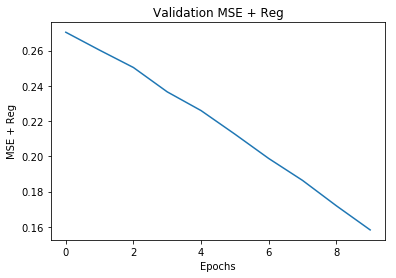

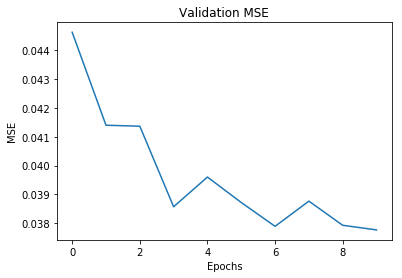

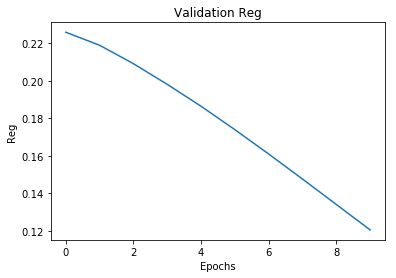

In [8]:
from dpp_nets.helper.plotting import plot_floats

# Training Plots
plot_floats(model['val_loss'], xlabel='Epochs', ylabel='MSE + Reg', title='Validation MSE + Reg')
plot_floats(model['val_pred_loss'], xlabel='Epochs', ylabel='MSE', title='Validation MSE')
plot_floats(model['val_reg_loss'], xlabel='Epochs', ylabel='Reg', title='Validation Reg')

In [9]:
# Evaluation on Test Set

loss, pred_loss, reg_loss = evalset.computeLoss(trainer, model['mode'])
print(str.join(" | ", ['Test Set:', 'Loss: %.5f' % (loss), 
                              'Pred Loss: %.5f' % (pred_loss), 'Reg Loss: %.5f' % (reg_loss)]))

prec, extract = evalset.evaluatePrecision(trainer,model['mode'])
print(str.join(" | ", ['Test Set:', 'Precision: %.5f' % (prec), 'Extract: %.5f' % (extract)]))

Test Set: | Loss: 0.13299 | Pred Loss: 0.02681 | Reg Loss: 0.10618
Test Set: | Precision: 0.59634 | Extract: 0.04027


In [10]:
# Random Samples
evalset.sample(trainer, model['mode'])

index is: 403
('head',) {'0'} [('head',)]
('aroma',) {'1'} [('aroma',)]
('not',) {'1'} [('not',)]
('light',) {'0'} [('light',)]
('pours',) {'0'} [('pours',)]
Precision is: 1.0
Extraction Percentage is: 0.0684931506849315
[(I drank this from a 22oz bottle into a Rochefort chalice.		, set()), (The beer pours a dark orange with a hint of amber., {'0'}), (The head is light white with light retention and lacing.		, {'0'}), (The aroma is matly not a sweet citrus, just sugar malts with a hint of alcohol.		, {'1'}), (The taste is very watery with just a little bitter., set()), (This is very boring., set())]


In [11]:
evalset.vocab.returnEmbds(evalset.words[123].all.keys())

Variable containing:
 0.0122  0.0260 -0.0223  ...   0.0232 -0.0915  0.0043
 0.0215 -0.0009 -0.0301  ...   0.0484 -0.0304  0.0006
 0.0444 -0.0263  0.1317  ...  -0.0246 -0.0351  0.0362
          ...             ⋱             ...          
-0.0212 -0.1947  0.0044  ...  -0.0461  0.0342  0.0062
 0.0146 -0.0078 -0.1428  ...   0.0978 -0.0808 -0.0552
 0.0618  0.0355  0.1168  ...   0.0664 -0.0244 -0.1388
[torch.FloatTensor of size 38x200]

In [12]:
# Random Marginals
evalset.computeMarginals(trainer, model['mode'])

index is: 714
0 0.468348092144 ('head',)
1 0.325438330679 ('mouthfeel',)
2 0.285838222209 ('tan',)
3 0.244194318479 ('dark',)
4 0.235471907092 ('nose',)
5 0.230103170485 ('black',)
6 0.226348106844 ('complex',)
7 0.22369884818 ('preferred',)
8 0.222122835201 ('excellent',)
9 0.201923566884 ('beers',)
10 0.201641069181 ('reminded',)
11 0.189460365467 ('bottle',)
12 0.189221649304 ('followed',)
13 0.183352985279 ('notes',)
14 0.182974331155 ('1',)
15 0.179920892366 ('lot',)
16 0.177868949881 ('year',)
17 0.17485105209 ('layers',)
18 0.16791686624 ('flavors',)
19 0.163351702953 ("'s",)
20 0.151415164895 ('2010',)
21 0.14918118288 ('10',)
22 0.148137633416 ('fruit',)
23 0.147506496148 ('bottles',)
24 0.146497260113 ('pronounced',)
25 0.144315462636 ('pitch',)
26 0.141685753556 ('thanks',)
27 0.13333827614 ('caramel',)
28 0.131104197949 ('roastiness',)
29 0.130780961588 ('hops',)
30 0.124570664262 ('coffee',)
31 0.121294660685 ('malt',)
32 0.120533968753 ('aged',)
33 0.119367093054 ('09',)


In [13]:
### Check if model was constructed correctly by re-computing validation loss:
from dpp_nets.utils.language import Vocabulary, BeerDataset, simple_collate, custom_collate

val_path = '/Users/Max/data/beer_reviews/' + 'reviews.' + 'all' + '.heldout.' + 'chunks' + '.txt.gz'
val_set = BeerDataset(val_path)
val_loader = torch.utils.data.DataLoader(val_set, collate_fn=simple_collate, batch_size=10)

In [14]:
for i, batch in enumerate(val_loader, 1):
    review, target = custom_collate(batch, vocab, False)
    trainer(review, target)
    break